In [ ]:
#!pip install ucimlrepo

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
X.loc[:,'patient_nbr'] = diabetes_130_us_hospitals_for_years_1999_2008.data['ids']['patient_nbr'].copy()
X.loc[:,'encounter_id'] = diabetes_130_us_hospitals_for_years_1999_2008.data['ids']['encounter_id'].copy()
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

C:\Users\vallejju\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\vallejju\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\vallejju\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._

In [3]:
# Check null/empty values for each feature
X.isnull().sum().sort_values(ascending = False)

weight                      98569
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
examide                         0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
citoglipton                     0
glipizide                       0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
patient_nbr                     0
glyburide                       0
nateglinide                     0
acetohexamide                   0
number_outpati

In [4]:
# repeated observations, keep the one with more registers
for col_name in X.columns:
    print(X[col_name].value_counts(dropna = False))


Caucasian          76099
AfricanAmerican    19210
NaN                 2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64
Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64
NaN          98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64
1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64
1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      

In [5]:
# drop repeated patients and keep the first appareance
X_pre = X.drop_duplicates(subset = ['patient_nbr'])
# weigth because missing values, payer because medical reasons on readmitting, max glu lot of none, diag3 nan, admission source a lot of categories and redundant
X_pre = X_pre.drop(['weight', 'payer_code', 'acetohexamide', 'tolbutamide', 'examide', 'troglitazone', 'citoglipton', 
                    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'tolazamide',
                    'glipizide-metformin','glyburide-metformin', 'miglitol' ,'nateglinide' , 'acarbose', 'glyburide-metformin', 
                    'chlorpropamide',
                    'max_glu_serum', 'diag_3', 'admission_source_id', 'medical_specialty',
                    'patient_nbr', 'encounter_id'], axis=1)

In [6]:
# race fill na and gender change a few registers from invalid to Female
X_pre.fillna({'race':'Other'}, inplace = True)
X_pre.gender.replace('Unknown/Invalid', 'Female', inplace = True)

In [7]:
#TODO Admision type MAY not be considered, because the 2 main reasons cover more than 50% of data (emergency/urgent)
X_pre['admission_type_id'].value_counts(dropna = False)
# Considering we have so little obs for Newborn we do not include this category
# The rest are grouped in 3 categories as follow: Emergency (1), Urgent(2) and Trauma Center(7) in 'Urg', Elective remains the same, and the rest in Other
admission_to_delete = [4]
X_pre = X_pre[~X_pre['admission_type_id'].isin(admission_to_delete)]
dic_admission_type = {1:'Urg',
                     2:'Urg',
                     3:'Elec',
                     5:'Other',
                     6:'Other',
                     7:'Urg',
                     8:'Other',}
X_pre['admission_type_id'] = X_pre['admission_type_id'].map(dic_admission_type)
X_pre['admission_type_id'].value_counts()

Urg      49539
Elec     13917
Other     8053
Name: admission_type_id, dtype: int64

In [8]:
# Delete hospice and death people
discharge_to_delete = [11, 13, 14, 19, 20, 21]
X_pre = X_pre[~X_pre['discharge_disposition_id'].isin(discharge_to_delete)]
# Regroup the rest of reasons in 4 categories:
dic_discharge = {1:'Home',
                2:'Transfer',
                3:'Transfer',
                4:'Transfer',
                5:'Transfer',
                6:'Home_H',
                7:'Other',
                8:'Home_H',
                9:'Other',
                10:'Other',
                12:'Other',
                15:'Transfer',
                16:'Transfer',
                17:'Transfer',
                18:'Other',
                22:'Transfer',
                23:'Transfer',
                24:'Transfer',
                25:'Other',
                26:'Other',
                30:'Transfer',
                27:'Transfer',
                28:'Transfer',
                29:'Transfer'}
X_pre['discharge_disposition_id'] = X_pre['discharge_disposition_id'].map(dic_discharge)
X_pre['discharge_disposition_id'].value_counts()

Home        44312
Transfer    13616
Home_H       8358
Other        3678
Name: discharge_disposition_id, dtype: int64

In [9]:
X_pre['diag_1'].value_counts(dropna = False).sort_index()

10      1
11      8
110     2
112    45
114     1
       ..
V63     6
V67     1
V70     1
V71     8
NaN    10
Name: diag_1, Length: 694, dtype: int64

In [10]:
def transform_diag(diag_df):
    diag_df = diag_df.replace(to_replace ='^[EV]\d+', value = 1000, regex = True)
    # na as other
    diag_df.fillna(0, inplace = True)
    return diag_df.astype(float)

def replace_in_range(x):
    if x == 250:
        return "Diabetes"
    elif 240 <= x <= 279:
        return "Endocrine"
    elif 390 <= x <= 459:
        return "Circulatory"
    elif 460 <= x <= 519:
        return "Respiratory"
    elif 520 <= x <= 579:
        return "Digestive"
    elif 580 <= x <= 629:
        return "Genitourinary"
    elif 630 <= x <= 679:
        return "Musculoskeletal"
    elif 780 <= x <= 799:
        return "Ill-Defined"
    elif 800 <= x <= 999:
        return "Injury"
    else:
        return "Other"
    return x



In [11]:
X_pre['diag_1'] = transform_diag(X_pre['diag_1'])
X_pre['diag_1'] = X_pre[['diag_1']].applymap(replace_in_range)


X_pre['diag_2'] = transform_diag(X_pre['diag_2'])
X_pre['diag_2'] = X_pre[['diag_2']].applymap(replace_in_range)

In [12]:
X_pre['diabetesMed'].value_counts()

Yes    53286
No     16678
Name: diabetesMed, dtype: int64

In [13]:
X_pre['A1Cresult'].value_counts()

None    57121
>8       6239
Norm     3741
>7       2863
Name: A1Cresult, dtype: int64

In [14]:
y_pre = y.iloc[X_pre.index,:]

In [15]:
y_pre.value_counts()

readmitted
NO            41468
>30           22220
<30            6276
dtype: int64

In [16]:
# Group the output in two categories: readmitted or not readmitted
y_pre = y_pre.replace(['NO', '>30', '<30'], [0,1,1])

In [17]:
y_pre.value_counts()

readmitted
0             41468
1             28496
dtype: int64

# Feature Engineering

## One Hot Encoding

In [18]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
# Reshape data to fit the encoder input
categories_ohe = X_pre[['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'diag_1', 'diag_2']]
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(categories_ohe)
# Transform categories
encoded_categories = encoder.transform(categories_ohe)
categories_ = encoder.categories_
feature_names = []
for i, category in enumerate(categories_):
    feature_name = categories_ohe.columns[i]
    feature_names.extend([f"{feature_name}_{cat}" for cat in category])
# Create a new DataFrame for encoded categories
X_new = pd.DataFrame(encoded_categories, columns=feature_names)

In [19]:
X_new.columns

Index(['race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'gender_Female', 'gender_Male', 'admission_type_id_Elec',
       'admission_type_id_Other', 'admission_type_id_Urg',
       'discharge_disposition_id_Home', 'discharge_disposition_id_Home_H',
       'discharge_disposition_id_Other', 'discharge_disposition_id_Transfer',
       'diag_1_Circulatory', 'diag_1_Diabetes', 'diag_1_Digestive',
       'diag_1_Endocrine', 'diag_1_Genitourinary', 'diag_1_Ill-Defined',
       'diag_1_Injury', 'diag_1_Musculoskeletal', 'diag_1_Other',
       'diag_1_Respiratory', 'diag_2_Circulatory', 'diag_2_Diabetes',
       'diag_2_Digestive', 'diag_2_Endocrine', 'diag_2_Genitourinary',
       'diag_2_Ill-Defined', 'diag_2_Injury', 'diag_2_Musculoskeletal',
       'diag_2_Other', 'diag_2_Respiratory'],
      dtype='object')

## Other transformations

In [20]:
# Custom encoding for the medication features
drugs = ['metformin', 'repaglinide', 'glimepiride', 'glipizide',
           'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']
for col in drugs:
    X_new[col] = X_pre[col].replace(['No','Steady','Up','Down'],[0,1,1,1]).values
    print(X_new[col].value_counts())
    X_new[col] = X_new[col].astype(float)

0    55062
1    14902
Name: metformin, dtype: int64
0    69047
1      917
Name: repaglinide, dtype: int64
0    66268
1     3696
Name: glimepiride, dtype: int64
0    60957
1     9007
Name: glipizide, dtype: int64
0    62189
1     7775
Name: glyburide, dtype: int64
0    64702
1     5262
Name: pioglitazone, dtype: int64
0    65303
1     4661
Name: rosiglitazone, dtype: int64
1    35710
0    34254
Name: insulin, dtype: int64


In [21]:
# Transform the age variable to numeric, using the middle point of the given range
unique_vals_age = X_pre.age.value_counts()
dic_for_df = {}
for age in unique_vals_age.index:
    age_range = age.replace('[', '').replace(')','').split('-')
    min_age = int(age_range[0]); max_age = int(age_range[1]); final_age = (max_age-min_age)/2 + min_age
    dic_for_df[age] = final_age
    #print(age, max_age, min_age, final_age)
X_new['age'] = X_pre.age.replace(dic_for_df).values


In [22]:
# Label Encoding for A1Cresult
X_new['A1Cresult'] = X_pre['A1Cresult'].replace(['>8','>7','Norm','None'],[3,2,1,0]).values

In [23]:
# Boolean vector for change and diabetesMed
X_new['change'] = X_pre['change'].replace(['No','Ch'],[0,1]).values
X_new['diabetesMed'] = X_pre['diabetesMed'].replace(['No','Yes'],[0,1]).values

In [24]:
# Scaling the numerical variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_features = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'number_outpatient' , 'number_emergency',
                  'number_inpatient', 'num_medications']
X_num_scaled = X_pre[num_features].copy()
scaler.fit(X_num_scaled)
X_num_scaled = scaler.transform(X_num_scaled)
X_num_scaled = pd.DataFrame(X_num_scaled, columns = num_features)

In [25]:
X_new['time_in_hospital'] = X_num_scaled['time_in_hospital'].values
X_new['num_lab_procedures'] = X_num_scaled['num_lab_procedures'].values
X_new['num_procedures'] = X_num_scaled['num_procedures'].values
X_new['number_outpatient'] = X_num_scaled['number_outpatient'].values
X_new['number_emergency'] = X_num_scaled['number_emergency'].values
X_new['number_inpatient'] = X_num_scaled['number_inpatient'].values
X_new['num_medications'] = X_num_scaled['num_medications'].values

In [26]:
X_new[['time_in_hospital','num_lab_procedures','num_procedures', 
       'num_medications','number_outpatient', 'number_emergency','number_inpatient']].corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient
time_in_hospital,1.000000,0.332203,0.188318,0.467900,-0.015456,-0.010055,0.063951
num_lab_procedures,0.332203,1.000000,0.043792,0.258984,-0.008027,0.015469,0.079739
num_procedures,0.188318,0.043792,1.000000,0.400918,-0.018676,-0.035388,-0.023699
num_medications,0.467900,0.258984,0.400918,1.000000,0.027006,0.003180,0.039357
number_outpatient,-0.015456,-0.008027,-0.018676,0.027006,1.000000,0.094850,0.068752
number_emergency,-0.010055,0.015469,-0.035388,0.003180,0.094850,1.000000,0.147723
number_inpatient,0.063951,0.079739,-0.023699,0.039357,0.068752,0.147723,1.000000


# Metrics for models comparison

In [40]:
#from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,recall_score,mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
#from sklearn.metrics import classification_report
#import sklearn.metrics as metrics
#from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score,f1_score

def get_scores(y_actual, y_pred, thresh = 0.5):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    fscore = f1_score(y_actual,(y_pred > thresh) )
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('fscore:%.3f'%fscore)
    print(' ')
    return auc, accuracy, recall, precision,fscore

# Data split

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new.to_numpy(), y_pre.values.ravel(), test_size = 0.3, random_state = 42)

# PCA

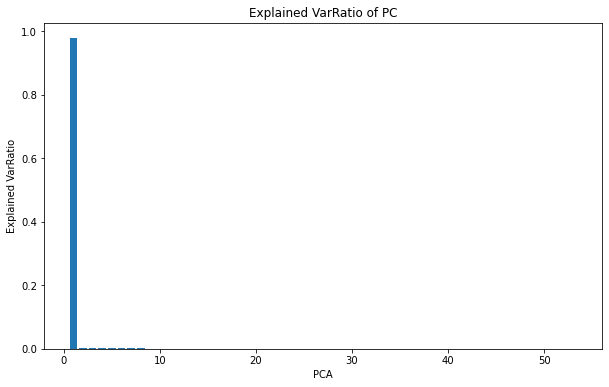

Feature importance for the first PC:
A1Cresult                             0.134445
discharge_disposition_id_Home         0.134392
diag_1_Endocrine                      0.061688
race_AfricanAmerican                  0.060133
diag_2_Endocrine                      0.046445
insulin                               0.046430
gender_Male                           0.026007
diag_2_Other                          0.024346
metformin                             0.020825
diag_1_Musculoskeletal                0.018367
change                                0.015735
diag_2_Diabetes                       0.014955
diag_2_Musculoskeletal                0.011260
admission_type_id_Elec                0.011250
race_Hispanic                         0.010027
diabetesMed                           0.009653
diag_1_Ill-Defined                    0.008149
num_procedures                        0.006311
diag_1_Other                          0.005324
discharge_disposition_id_Other        0.004559
diag_2_Digestive       

In [42]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=X_train.shape[1])
X_pca = pca.fit_transform(X_train)

# Get the explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Create a bar plot of the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, align='center')
plt.xlabel('PCA')
plt.ylabel('Explained VarRatio')
plt.title('Explained VarRatio of PC')
plt.show()

# Get the loadings (feature importance) for each principal component
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=X_new.columns)

# Display the loadings for the first principal component (PC1)
print("Feature importance for the first PC:")
print(loadings_df['PC1'].sort_values(ascending=False))

# Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver = "liblinear").fit(X_train, y_train)

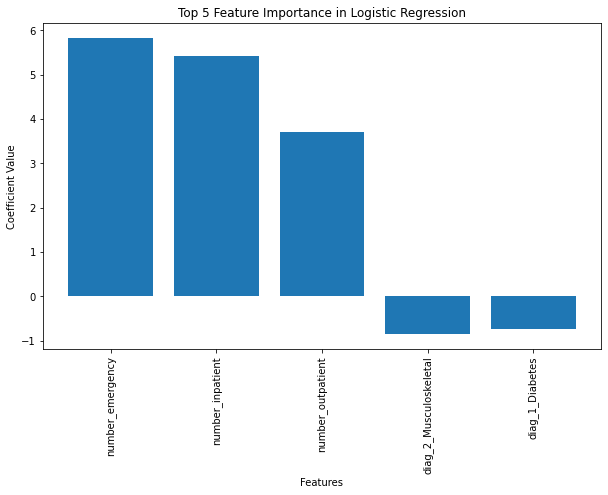

In [44]:
# Get the coefficients and feature names
coefficients = log_reg.coef_[0]
feature_names = X_new.columns

# Create a bar plot of the top 5 coefficients
top_indices = np.argsort(np.abs(coefficients))[::-1][:5]
plt.figure(figsize=(10, 6))
plt.bar(range(5), coefficients[top_indices])
plt.xticks(range(5), feature_names[top_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Top 5 Feature Importance in Logistic Regression')
plt.show()

In [45]:
y_train_preds = log_reg.predict_proba(X_train)[:,1]
y_test_preds = log_reg.predict_proba(X_test)[:,1]

print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_fscore = get_scores(y_train,y_train_preds)
print('Validation:')
lr_test_auc, lr_test_accuracy, lr_test_recall, \
    lr_test_precision,lr_test_fscore = get_scores(y_test,y_test_preds)

Training:
AUC:0.628
accuracy:0.622
recall:0.221
precision:0.595
fscore:0.322
 
Validation:
AUC:0.627
accuracy:0.622
recall:0.226
precision:0.601
fscore:0.328
 


# Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
depths = [2, 4, 6, 8, 10]
acc_list =[]
for i, d in enumerate(depths):
    model = DecisionTreeClassifier(random_state = 18, criterion = 'entropy', max_depth = d)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_list.append(accuracy_score(y_test, y_pred))

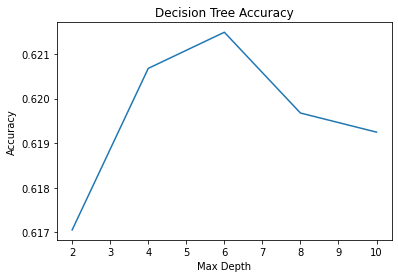

In [48]:
plt.figure()
plt.plot(depths, acc_list)
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.title('Decision Tree Accuracy')
plt.show()

In [49]:
dt_model = DecisionTreeClassifier(random_state = 18, max_depth = 6)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=18)

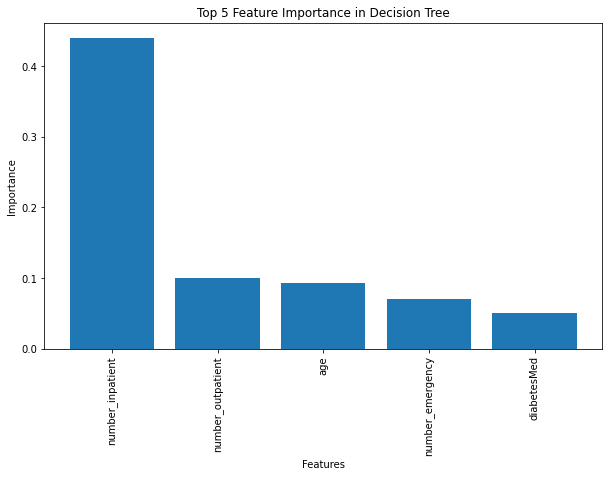

In [50]:
# Get the feature importances and feature names
importances = dt_model.feature_importances_
feature_names = X_new.columns

# Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]

# Get the indices of the top 5 features sorted by importance
top_indices = np.argsort(importances)[::-1][:5]

# Create a bar plot of the top 5 feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(5), importances[top_indices], align='center')
plt.xticks(range(5), feature_names[top_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 5 Feature Importance in Decision Tree')
plt.show()

In [51]:
y_train_preds = dt_model.predict_proba(X_train)[:,1]
y_test_preds = dt_model.predict_proba(X_test)[:,1]

print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_fscore = get_scores(y_train,y_train_preds)
print('Validation:')
lr_test_auc, lr_test_accuracy, lr_test_recall, \
    lr_test_precision,lr_test_fscore = get_scores(y_test,y_test_preds)

Training:
AUC:0.623
accuracy:0.630
recall:0.266
precision:0.601
fscore:0.369
 
Validation:
AUC:0.613
accuracy:0.621
recall:0.261
precision:0.579
fscore:0.360
 


# Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier


In [55]:
n_est = [100, 200, 300, 400, 500]
acc_list_rf =[]
for i, trees in enumerate(n_est):
    model = RandomForestClassifier(n_estimators=trees, criterion='entropy', max_depth=3, n_jobs=4, random_state = 42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_list_rf.append(accuracy_score(y_test, y_pred))

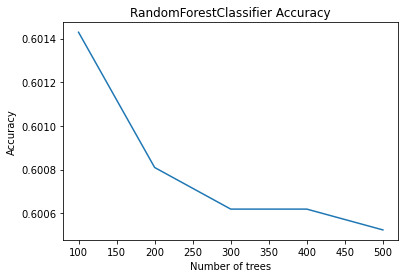

In [56]:
plt.figure()
plt.plot(n_est, acc_list_rf)
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.title('RandomForestClassifier Accuracy')
plt.show()

In [57]:
random_forest_model = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=3, n_jobs=4)
random_forest_model.fit(X_train, y_train) 

RandomForestClassifier(criterion='entropy', max_depth=3, n_jobs=4)

In [58]:
y_train_preds = random_forest_model.predict_proba(X_train)[:,1]
y_test_preds = random_forest_model.predict_proba(X_test)[:,1]

print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_fscore = get_scores(y_train,y_train_preds)
print('Validation:')
lr_test_auc, lr_test_accuracy, lr_test_recall, \
    lr_test_precision,lr_test_fscore = get_scores(y_test,y_test_preds)

Training:
AUC:0.629
accuracy:0.604
recall:0.044
precision:0.726
fscore:0.082
 
Validation:
AUC:0.633
accuracy:0.602
recall:0.044
precision:0.703
fscore:0.082
 
